In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, Latex

from sklearn.linear_model import LinearRegression
model = LinearRegression()

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
ids = pd.read_csv("../ds/inflation.csv").query("""
    INDICATOR == 'CPI' and MEASURE == 'AGRWTH' and SUBJECT == 'TOT'
""")

uds = pd.read_csv("../ds/unemployment.csv").query("""
    SUBJECT == 'TOT'
""")

ods = pd.read_csv("../ds/oil.csv")

In [2]:
country = "USA"
factors = ["Unemployment Deviation", "Oil Price", "Previous Month Inflation"]

sy = 2019 # 3 years
ly = 2010 # 10 years
ey = 2021 # excluding this year

endYear = str(ey)
endPrevYear = str(ey - 1)
places = 3 # decimal Places

In [3]:
class run:
    i = 5
    u = 5
    o = 5
    e = 5
    text = ""
    file = ""
    query = ""
    year = ""
    prevYear = ""
    freq = ''

s = run()
s.year = str(sy)
s.prevYear = str(sy - 1)
s.freq = 'M'
s.text = "Short Run"
s.file = "sr"


l = run()
l.year = str(ly)
l.prevYear = str(ly - 1)
l.freq = 'A'
l.text = "Long Run"
l.file = "lr"

runs = [s, l]

In [4]:
for run in runs:
    run.query = """
        TIME > @run.year and TIME < @endYear and FREQUENCY == @run.freq
    """
    run.i = ids.query(run.query)
    run.u = uds.query(run.query)
    run.o = ods.query(run.query)
    run.e = ids.query("""
        TIME > @run.prevYear and TIME < @endPrevYear and FREQUENCY == @run.freq
    """)

    i = run.i.query("LOCATION == @country")["Value"].reset_index(drop=True)

    u = run.u.query("LOCATION == @country")["Value"].reset_index(drop=True)
    uDev = u - u.mean()
    run.uMean = u.mean() # needed for finding dataset unemployment deviation
    
    o = run.o.query("LOCATION == @country")["Value"].reset_index(drop=True)

    iprev = run.e.query("LOCATION == @country")["Value"].reset_index(drop=True)[0]
    if iprev is None: # data not available
        e = pd.Series( i.mean() )
    else:
        e = pd.Series( iprev ) 
    e = e.append(i, ignore_index=True).iloc[:-1]
   
    run.frame = { 
        factors[0]: uDev,
        factors[1]: o,
        factors[2]: e,

        "Current Inflation": i,
    }
    run.df = pd.DataFrame(run.frame)
    
    run.normalizedFrame = { 
        factors[0]: ( uDev - uDev.mean() )/uDev.std(),
        factors[1]: ( o - o.mean() )/o.std(),
        factors[2]: ( e - e.mean() )/e.std(),

        "Current Inflation": i,
    }
    run.normalizedDf = pd.DataFrame(run.normalizedFrame)

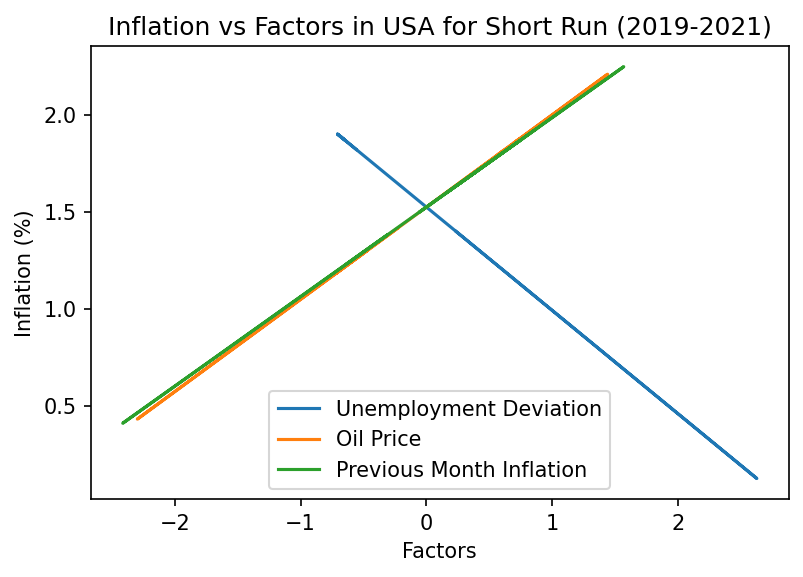

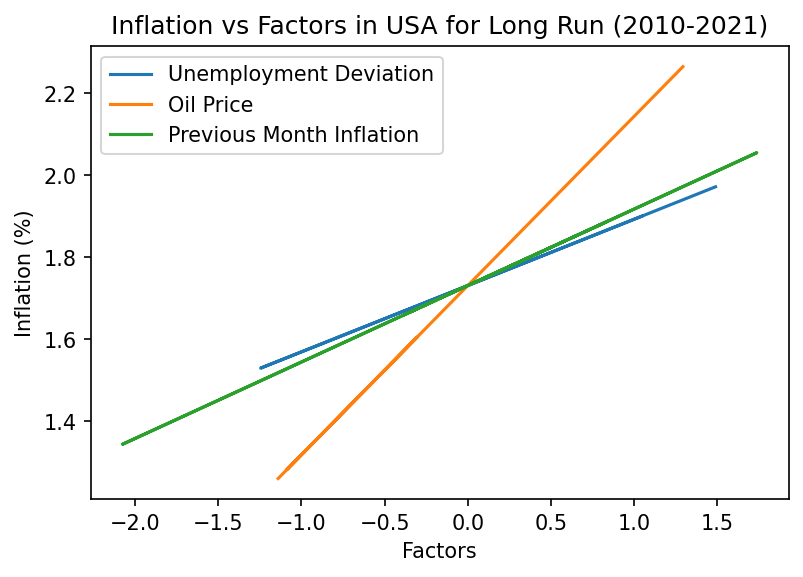

In [5]:
text = "Factors"#"($ u- \overline{u}$ )"
for run in runs:
    plt.figure(dpi=150).patch.set_facecolor('white')
    for factor in factors:
        x = run.normalizedDf[[ factor ]]
        model.fit(x, run.normalizedDf["Current Inflation"])
        plt.plot(x, model.predict(x), label = factor)

    plt.title(
        "Inflation vs " + text + " in " + country + " for " + run.text + " (" + run.year + "-" + endYear + ")"
    )
    plt.xlabel(text), plt.ylabel("Inflation (%)"), plt.legend()

    plt.savefig("../img/" + run.file + ".svg", dpi=300, bbox_inches = 'tight')
    plt.show()

In [6]:
model.fit(s.df[factors], s.df["Current Inflation"])

print("The regression equation in", s.text, "for", country)

display(Math(r"\pi_t = " +
    str( round( model.intercept_, places) ) +
    str( round(model.coef_[0], places) ) + "( u_t - \overline u )" +
    "+" + str( round(model.coef_[1], places) ) + "( O_t )" +
    "+" + str( round(model.coef_[2], places) ) + "( \pi_{t-1} )" 
))

print("(Rounded-off to", places, "places for viewing)")

The regression equation in Short Run for USA


<IPython.core.display.Math object>

(Rounded-off to 3 places for viewing)


In [7]:
s.df["Predicted Inflation"] = model.predict( s.df[factors] )

s.df["% Error"] = 100 * (s.df["Predicted Inflation"] - s.df["Current Inflation"]) / s.df["Current Inflation"]

print("Comparing model with the first few observations of training set in", s.text)

round(s.df.head(), places)

Comparing model with the first few observations of training set in Short Run


,Unemployment Deviation,Oil Price,Previous Month Inflation,Current Inflation,Predicted Inflation,% Error
0,-1.896,46.76,2.071,1.551,1.837,18.426
1,-2.096,54.14,1.551,1.520,1.776,16.864
2,-2.096,58.67,1.520,1.863,1.821,-2.223
3,-2.196,63.04,1.863,1.996,1.990,-0.329
4,-2.196,64.67,1.996,1.790,2.052,14.619


In [11]:
print("Using model for test set in", s.text)

# test = pd.read_csv("../ds/test.csv")
test = pd.read_excel("../ds/test.xlsx")

test[factors[0]] = test.iloc[:, 0] - s.uMean
test["Predicted Inflation"] = model.predict( test[factors] )

round(test, places)

Using model for test set in Short Run


,Unemployment,Oil Price,Previous Month Inflation,Unemployment Deviation,Predicted Inflation
0,2.000,55.000,1.500,-3.896,1.908
1,7.000,55.000,1.500,1.104,1.526
2,15.000,55.000,1.500,9.104,0.916
3,4.546,60.785,2.939,-1.350,2.239
4,5.784,52.383,1.811,-0.112,1.686
5,5.808,63.889,2.200,-0.088,1.946
6,4.963,64.065,2.099,-0.933,1.981
7,6.679,54.474,2.986,0.783,2.016
8,5.000,70.000,3.000,-0.896,2.335
